### Gaussian example (used in Figure 1.)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from rnpe.tasks import Gaussian
from jax import random

sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
colors = ["#072D41", "#ECA918", "#60B3C8", "#359735"]
plt.rcParams['axes.axisbelow'] = True
results_dir = "../../results"

seed = 0
slab_scale = 0.25
hyperprior=False
misspecified = True
file = f"seed={seed}_slab_scale={slab_scale}_hyperprior={hyperprior}_misspecified={misspecified}"
fn = f"{results_dir}/Gaussian/{file}.pickle"

plt.rcParams['axes.grid'] = False

with open(fn, "rb") as f:
    results = pickle.load(f)

### Plot denoised scatterplot

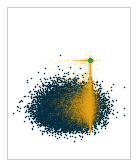

In [4]:
n = 20000
textwidth = 5.5

plt.figure(figsize=(textwidth*0.4, 2.8))

plt.scatter(
    x=results["data"]["x"][:n, 0],
    y=results["data"]["x"][:n, 1],
    color=colors[0],
    s=0.5,
    )

plt.scatter(
    x=results["mcmc_samples"]["x"][:n, 0],
    y=results["mcmc_samples"]["x"][:n, 1],
    color=colors[1],
    s=0.5,
    alpha=0.1,
    )

plt.scatter(
    x=results["data"]["y"][0],
    y=results["data"]["y"][1],
    color=colors[3],
    s=20,
    )

plt.tick_params(
    axis='both',         
    which='both',
    labelleft=False,
    labelbottom=False)

x_names = [r"$x_1$", r"$x_2$"]
plt.ylim((0.25, 2.5))
plt.rc('axes', axisbelow=True)
plt.savefig(f"{results_dir}/plots/basic_example_denoised.png", dpi=400)

In [5]:
print(results["mcmc_samples"]["misspecified"].mean(axis=0))

[0.52536 0.97158]


### Plot posterior densities

In [52]:
import numpy as np

keys = random.split(random.PRNGKey(0))

obs = results["data"]["y"]
true_posterior_samps = Gaussian().get_true_posterior_samples(
    key=keys[0],
    y=obs,
    n=n
    ).reshape(-1)
prior_samps = Gaussian().sample_prior(keys[1], n)[:, 0]


In [53]:
import pandas as pd
posterior_df = pd.concat(
    [
        pd.DataFrame(
        {"Source": "Prior",
        "theta": prior_samps
        }),
        pd.DataFrame(
        {"Source": "True",
        "theta": true_posterior_samps
        }),
        pd.DataFrame({
        "Source": "RNPE",
        "theta": results["posterior_samples"]["RNPE"][:n, 0]
        }),
    pd.DataFrame(
        {"Source": "NPE",
        "theta": results["posterior_samples"]["NPE"][:n, 0]
        }),
    ]
)
posterior_df["Source"] = pd.Categorical(posterior_df["Source"], ["Prior", "True", "NPE", "RNPE"])

from plotnine import ggplot, aes, geom_density, xlim, theme_bw, scale_color_manual, scale_fill_manual, xlab, theme, element_blank, element_text, ylab
font_kwargs = {"family": "Times New Roman", "size": 11}
txt = element_text(**font_kwargs)

In [66]:
import jax.numpy as jnp
lims = jnp.quantile(true_posterior_samps, jnp.array([0.1, 0.9]))
lims = [lims[0].item() - 1.5, lims[1].item() + 1.5]


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 2.2 x 1.5 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../../results/plots/basic_example_posterior.png
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 20377 rows containing non-finite values.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 20377 rows containing non-finite values.


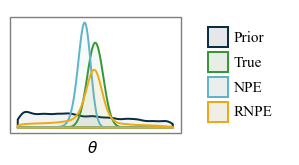

<ggplot: (8729986134390)>

In [67]:

p = (ggplot(posterior_df, aes(x="theta", color="Source", fill="Source")) +
geom_density(alpha=0.05, size=0.8, bw=0.1) +
scale_color_manual(values=[colors[0], colors[3], colors[2], colors[1]]) +
scale_fill_manual(values=[colors[0], colors[3], colors[2], colors[1]]) +
theme_bw() +
xlab(r"$\theta$") +
xlim(lims) +
ylab("") +
theme(
    legend_title=element_blank(),
    text=txt,
    figure_size=(textwidth*0.4, 1.5),
    panel_grid_minor=element_blank(),
    panel_grid_major=element_blank(),
    axis_text=element_blank(),
    axis_ticks=element_blank()
))

p.save(f"{results_dir}/plots/basic_example_posterior.png", dpi=400)
p